# ERA5 GRIB Quickstart: Load, Summarise, and Plot

This notebook opens your ERA5 GRIB file (unzipped from `era5-o48-2020-2021-6h-v1.zip`),
shows what's inside, and makes a couple of simple plots.

## What you'll need
- Python 3.10+
- Packages: `xarray`, `cfgrib`, `eccodes` (runtime dependency for `cfgrib`), `numpy`, `pandas`, `matplotlib`, and `cartopy`.

### Installation tips (run in a terminal, **not** in the notebook)
```bash
pip install xarray cfgrib eccodes numpy pandas matplotlib cartopy
```

If Cartopy install is troublesome, try a Conda environment:
```bash
conda create -n era5 python=3.11 xarray cfgrib eccodes numpy pandas matplotlib cartopy -c conda-forge
conda activate era5
```

If your GRIB has multiple message groups, we handle that below.


In [2]:
# --- Setup imports ---
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 5)

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False
    print("Cartopy not available; map plots will fall back to simple imshow().")

import warnings
warnings.filterwarnings('ignore')

print("Versions:")
for mod in (np, pd, xr):
    print(mod.__name__, mod.__version__)


Versions:
numpy 2.3.3
pandas 2.3.3
xarray 2025.9.1


## 1) Point the notebook at your GRIB file
Update the `grib_path` below if your filename is different or it's in another folder.

In [3]:
grib_path = Path('data.grib')  # change if needed
assert grib_path.exists(), f"GRIB file not found: {grib_path!s}"
grib_path

PosixPath('data.grib')

## 2) Open the GRIB with xarray + cfgrib
Some ERA5 GRIB files contain *multiple GRIB message groups* (e.g., different parameter tables, levels, etc.).
We try a straightforward open first; if that fails or yields no data variables, we read all groups and merge them.

In [4]:
def open_era5_grib(path: Path) -> xr.Dataset:
    # First attempt: a simple open
    try:
        ds = xr.open_dataset(path, engine='cfgrib')
        if len(ds.data_vars) > 0:
            return ds
    except Exception as e:
        print("Simple open failed, will try grouped open via cfgrib.open_datasets().\n", e)

    # Fallback: open all groups and merge along common dims
    import cfgrib
    groups = cfgrib.open_datasets(str(path))
    print(f"Found {len(groups)} message group(s). Variables per group:")
    for i, g in enumerate(groups):
        print(f"  Group {i}: {list(g.data_vars)}")
    # Try to combine by coordinates (robust for matching dims)
    ds_merged = xr.merge(groups, compat='no_conflicts', join='outer')
    return ds_merged

ds = open_era5_grib(grib_path)
ds

skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/Users/andrewparnell/GitHub/STAT41130/.venv/lib/python3.11/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/andrewparnell/GitHub/STAT41130/.venv/lib/python3.11/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1704067200, 1704070800, 1704074400, ..., 1735678800, 1735682400,
       1735686000], shape=(8784,))) new_value=Variable(dimensions=('time',), data=array([1704045600, 1704088800, 1704132000, 1704175200, 1704218400,
       1704261600, 1704304800, 1704348000, 1704391200, 1704434400,
       1704477600, 1704520800, 1704564000, 1704607200, 1704650400,
       1704693600, 1704736800, 1704780000, 1704823200, 1704866400,
       1704909600, 1704952800, 1704996

<xarray.Dataset> Size: 229MB
Dimensions:     (time: 8784, latitude: 41, longitude: 53)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 328B 61.0 60.75 60.5 ... 51.5 51.25 51.0
  * longitude   (longitude) float64 424B -11.0 -10.75 -10.5 ... 1.5 1.75 2.0
    valid_time  (time) datetime64[ns] 70kB ...
Data variables:
    u10         (time, latitude, longitude) float32 76MB ...
    v10         (time, latitude, longitude) float32 76MB ...
    t2m         (time, latitude, longitude) float32 76MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T16:13 GRIB to CDM+CF via cfgrib-0.9.1...

## 3) Quick dataset tour
- Dimensions and coordinates
- Variables and attributes
- Time coverage
- Spatial coverage (lat/lon bounds)


In [5]:
display(ds)  # rich repr in Jupyter
print('\nCoordinates:', list(ds.coords))
print('Data variables:', list(ds.data_vars))
time_name = 'time' if 'time' in ds.coords else [c for c in ds.coords if 'time' in c][0]
t0 = pd.to_datetime(ds[time_name].values[0]).to_pydatetime()
t1 = pd.to_datetime(ds[time_name].values[-1]).to_pydatetime()
print(f"Time coverage: {t0} — {t1} ({ds[time_name].size} steps)")

lat_name = 'latitude' if 'latitude' in ds.coords else 'lat'
lon_name = 'longitude' if 'longitude' in ds.coords else 'lon'
lat_min = float(ds[lat_name].min())
lat_max = float(ds[lat_name].max())
lon_min = float(ds[lon_name].min())
lon_max = float(ds[lon_name].max())
print(f"Latitude range: {lat_min:.2f} to {lat_max:.2f}")
print(f"Longitude range: {lon_min:.2f} to {lon_max:.2f}")


<xarray.Dataset> Size: 229MB
Dimensions:     (time: 8784, latitude: 41, longitude: 53)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 328B 61.0 60.75 60.5 ... 51.5 51.25 51.0
  * longitude   (longitude) float64 424B -11.0 -10.75 -10.5 ... 1.5 1.75 2.0
    valid_time  (time) datetime64[ns] 70kB ...
Data variables:
    u10         (time, latitude, longitude) float32 76MB ...
    v10         (time, latitude, longitude) float32 76MB ...
    t2m         (time, latitude, longitude) float32 76MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T16:13 GRIB to CDM+CF via cfgrib-0.9.1...


Coordinates: ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
Data variables: ['u10', 'v10', 't2m']
Time coverage: 2024-01-01 00:00:00 — 2024-12-31 23:00:00 (8784 steps)
Latitude range: 51.00 to 61.00
Longitude range: -11.00 to 2.00


## 4) Per-variable basic statistics
We compute min, max, mean, std across the full dataset for each data variable (lazy where possible).

In [6]:
stats_rows = []
for v in ds.data_vars:
    da = ds[v]
    try:
        stats = {
            'variable': v,
            'attrs_units': da.attrs.get('units', ''),
            'mean': float(da.mean().values),
            'std': float(da.std().values),
            'min': float(da.min().values),
            'max': float(da.max().values),
        }
        stats_rows.append(stats)
    except Exception as e:
        print(f"Skipping stats for {v}: {e}")

stats_df = pd.DataFrame(stats_rows).set_index('variable')
stats_df


,attrs_units,mean,std,min,max
variable,,,,,
u10,m s**-1,1.851291,5.482626,-23.640564,27.736511
v10,m s**-1,1.186740,5.691694,-24.437195,24.081985
t2m,K,283.334045,3.781185,261.992432,305.619873


## 5) Plot a map snapshot
Pick a variable and time index. We try to use Cartopy for proper map projection; if it's not
available, we fall back to a simple image plot in data coordinates.

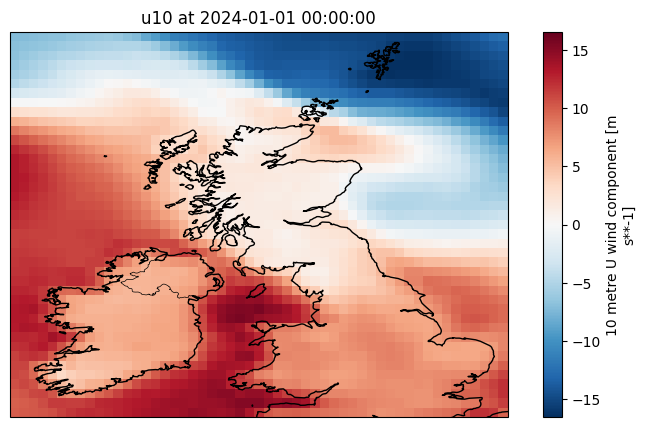

In [7]:
# Choose a variable that looks 2D in space + time (e.g., 't2m', 'u10', etc.)
var_candidates = [v for v in ds.data_vars if set(ds[v].dims) >= {lat_name, lon_name}]
assert var_candidates, 'No 2D spatial variable found to plot.'
var = var_candidates[0]
tidx = 0  # first time step; change as you like
da = ds[var].isel({time_name: tidx}) if time_name in ds[var].dims else ds[var]

title = f"{var} at {pd.to_datetime(ds[time_name].values[tidx]) if time_name in ds[var].dims else 'static'}"
if HAS_CARTOPY:
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title)
    plt.show()
else:
    da.plot()
    plt.title(title)
    plt.show()


## 6) Extract a time series near Dublin and plot
We pick coordinates near Dublin (53.35°N, -6.26°E) and grab the nearest grid point.

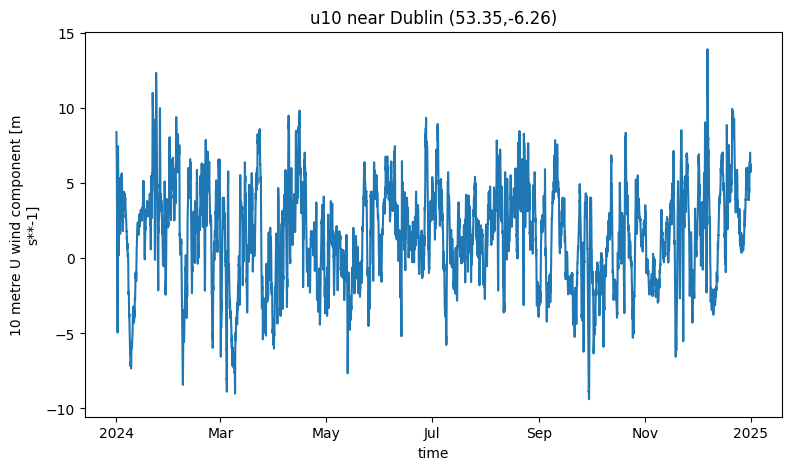

In [8]:
dublin_lat, dublin_lon = 53.35, -6.26

# ERA5 longitudes are often [0, 360). Convert if needed.
lon_vals = ds[lon_name]
if float(lon_vals.max()) > 180:
    # convert target lon to [0,360)
    target_lon = (dublin_lon + 360) % 360
else:
    target_lon = dublin_lon

var_ts_candidates = [v for v in ds.data_vars if time_name in ds[v].dims]
assert var_ts_candidates, 'No time-varying variable found.'
var_ts = var_ts_candidates[0]

da_ts = ds[var_ts].sel({lat_name: dublin_lat, lon_name: target_lon}, method='nearest')
if lat_name in da_ts.dims:
    da_ts = da_ts.squeeze(drop=True)
da_ts.plot()
plt.title(f"{var_ts} near Dublin ({dublin_lat:.2f},{dublin_lon:.2f})")
plt.xlabel('time')
plt.show()


## 7) Simple monthly climatology (groupby-plot)
As an example, we compute a monthly mean for the selected time series.

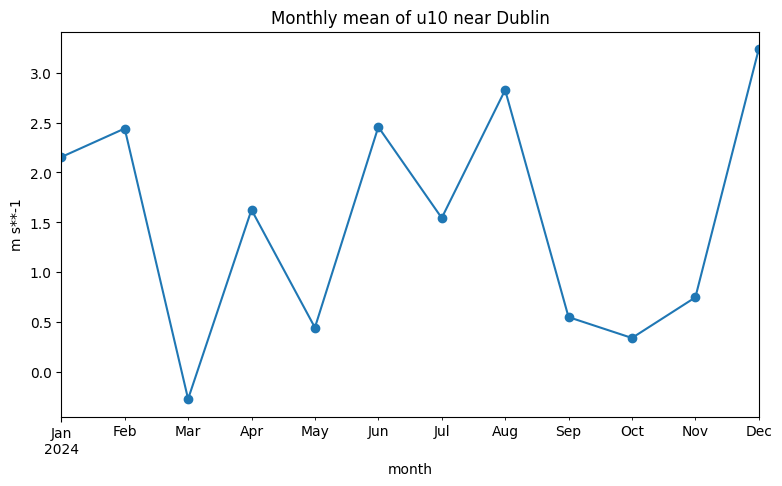

In [9]:
ts = da_ts.to_series()
monthly = ts.groupby([ts.index.year, ts.index.month]).mean()
monthly.index = pd.period_range(
    start=f"{ts.index.min().year}-{ts.index.min().month:02d}",
    periods=len(monthly), freq='M'
)
monthly.plot(marker='o')
plt.title(f"Monthly mean of {var_ts} near Dublin")
plt.xlabel('month')
plt.ylabel(ds[var_ts].attrs.get('units', ''))
plt.show()


## 8) Save a NetCDF copy (optional)
If you prefer a more portable format, you can write out the merged dataset to NetCDF.

In [ ]:
# Uncomment to save (can take a little while depending on dataset size)
# ds.to_netcdf('era5_merged.nc')
print('Done.')